In [1]:
#plot charts in the notebook
%matplotlib inline

#load some useful libraries
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.fftpack import fft

from IPython.display import HTML, display_html

import random

In [17]:
from sklearn.multioutput import MultiOutputRegressor

from sklearn.svm import SVR

from xgboost import XGBRegressor

import chocolate as choco

import pandas as pd

from chocolate import SQLiteConnection

In [3]:
#multi-section pendulum simulation
def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(forces, particles)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

In [4]:
#post processing function for pendulum simulation data
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

def animate_pendulum(x,y,t,lengths):  
    fig, ax = plt.subplots(figsize=(3,5),facecolor='red')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    limit=lengths.sum()
    ax.set(xlim=(-limit-1, limit+1), ylim=(-limit-1, limit+1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [9]:
pendulum_type = 5

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

#linear-ish "mustache"
start=83
initial_positions=[start,start,start,start,start] # starting angle of each section of pendulum
masses=[2.0,1.0,4.0,1.0,2.0] #mass of each point mass at the end of it's section
lengths=np.asarray([4,6,3,4,5])  #length of each section

#definitely non-linear
#initial_positions=[50,150] # starting angle of each section of pendulum
#masses=[1.5,1.0] #mass of each point mass at the end of it's section
#lengths=[0.5,2]  #length of each section

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)
p = integrate_pendulum(n=pendulum_type, times=t,initial_positions=initial_positions,masses=masses,lengths=lengths)
x_pend, y_pend = get_xy_coords(p,lengths)

anim = animate_pendulum(x_pend,y_pend,t,lengths)

HTML(anim.to_jshtml())


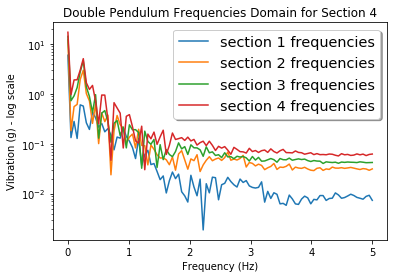

In [11]:

def estimate_frequencies(x_pos,y_pos,section,x_or_y,sampling_rate,bins):
    if x_or_y == 'x':
        direction = 0
    else:
        direction = 1
    
    # Nyquist Sampling Criteria
    T = 1/sampling_rate # inverse of the sampling rate
    frequencies = np.linspace(0.0, 1.0/(2.0*T), int(bins/2))

    # FFT algorithm
    yr = fft(y_pend[direction:bins,section]) # "raw" FFT with both + and - frequencies
    magnitudes = 2/bins * np.abs(yr[0:np.int(bins/2)]) # positive freqs only
    
    return frequencies,magnitudes
direction = 'x'
section = 1
frequencies1,magnitudes1 = estimate_frequencies(x_pend,y_pend,section=section,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)
section = 2
frequencies2,magnitudes2 = estimate_frequencies(x_pend,y_pend,section=section,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)
section = 3
frequencies3,magnitudes3 = estimate_frequencies(x_pend,y_pend,section=section,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)
section = 4
frequencies4,magnitudes4 = estimate_frequencies(x_pend,y_pend,section=section,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)
# Plotting the results
plt.plot(frequencies1, magnitudes1,label='section 1 frequencies')
plt.plot(frequencies2, magnitudes2,label='section 2 frequencies')
plt.plot(frequencies3, magnitudes3,label='section 3 frequencies')
plt.plot(frequencies4, magnitudes4,label='section 4 frequencies')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g) - log scale')
plt.yscale('log')
plt.title('Double Pendulum Frequencies Domain for Section '+str(section) );

In [12]:
num =1000

dataset3_X = np.empty(shape=(num,500)) #frequencies for sections 1 (0,99) and sections 2 (100,199)
dataset3_Y = np.empty(shape=(num,10)) #weight1,weight2,length1,length2

In [ ]:
##QUINT PENDULUM
#this is a bit slow - If you have a crummy computer skip this cell and load dataset1_Y.csv and dataset1_X.csv below instead 

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)

#linear-ish "mustache"
start = 83
initial_positions=[start,start,start,start,start] # starting angle of each section of pendulum
#masses=[5,2.5] we're going to vary this
#lengths=[1,10] we're going to vary this

for i in range(0,num):
    dataset3_Y[i] = np.random.uniform(low=0.5,high=1.5,size=10)
    p = integrate_pendulum(n=5, times=t,initial_positions=initial_positions,masses=dataset3_Y[i,0:5],lengths=dataset3_Y[i,5:10])
    x_pos, y_pos = get_xy_coords(p)
    yr1 = fft(y_pos[0:bins,1]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][0:100] = 2/bins * np.abs(yr1[0:np.int(bins/2)]) # positive freqs only
    yr2 = fft(y_pos[0:bins,2]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][100:200] = 2/bins * np.abs(yr2[0:np.int(bins/2)]) # positive freqs only
    yr3 = fft(y_pos[0:bins,3]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][200:300] = 2/bins * np.abs(yr3[0:np.int(bins/2)]) # positive freqs only
    yr4 = fft(y_pos[0:bins,4]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][300:400] = 2/bins * np.abs(yr4[0:np.int(bins/2)]) # positive freqs only
    yr5 = fft(y_pos[0:bins,5]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][400:500] = 2/bins * np.abs(yr5[0:np.int(bins/2)]) # positive freqs only
    
    

In [ ]:
#save dataset for anyone who doesn't want to regen data or has a potato computer and can't
#np.savetxt("dataset3_X.csv",dataset2_X,delimiter=',')
#np.savetxt("dataset3_Y.csv",dataset2_Y,delimiter=',')

In [13]:
#load saved dataset rather than generating your own
dataset3_X = np.loadtxt("dataset3_X.csv",delimiter=',')
dataset3_Y = np.loadtxt("dataset3_Y.csv",delimiter=',')

In [14]:
dataset3_X.shape

(1000, 500)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset3_X[300:399], dataset3_X[100:199], test_size=0.10, random_state=42)

In [16]:
x_scaler_nl = StandardScaler()
X_train_scaled_nl = x_scaler_nl.fit_transform(X_train)
X_test_scaled_nl = x_scaler_nl.transform(X_test)

y_scaler_nl = StandardScaler().fit(Y_train)
Y_train_scaled_nl = y_scaler_nl.transform(Y_train)
Y_test_scaled_nl = y_scaler_nl.transform(Y_test)

In [18]:
def build_Regressor(params):   
    if params['algo'] == 2: 
        return MultiOutputRegressor(XGBRegressor(n_estimators=int(params['n_estimators']),
                                           learning_rate=params['learning_rate'],
                                            gamma=0, 
                                            subsample=0.75,
                                            colsample_bytree=1,
                                            max_depth=int(params['max_depth'])
                                            ))
    if params['algo'] == 0: 
        return MultiOutputRegressor(SVR(kernel ="rbf", C = params['C'],gamma=params['gamma']))
    if params['algo'] == 1: 
        return MultiOutputRegressor(SVR(kernel ="poly", C = params['C'],gamma=params['gamma'],
                                       degree=int(params['degree']),
                                    coef0 = params['coef0']))

In [23]:
#build a function to create a model with arbitrary params, train, fit, test and return a score

def _score(X_train, X_test, Y_train, Y_test, y_scaler_nl, params):
    
    #create ML model
    model = build_Regressor(params)
    
    #train
    model.fit(X_train_scaled_nl, Y_train_scaled_nl)
    
    #predict
    Y_test_pred_scaled = model.predict(X_test_scaled_nl)
    
    #de-scale
    Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)

    # Chocolate minimizes the loss
    return mean_squared_error(Y_test_pred_unscaled, Y_test)

In [21]:
space = [{"algo" : 0, "kernel" : "rbf", #SVR
              "C" : choco.log(low=-2, high=10, base=10),
              "gamma" : choco.log(low=-9, high=3, base=10)},
         {"algo" : 1, "kernel" : "poly", #SVR
              "C" : choco.log(low=-2, high=10, base=10),
              "gamma" : choco.log(low=-9, high=3, base=10),
              "degree" : choco.quantized_uniform(low=1, high=5, step=1),
              "coef0" : choco.uniform(low=-1, high=1)},
         {"algo" : 2, #XGBoost
          "n_estimators":choco.quantized_uniform(50,500,50),
          "learning_rate":choco.quantized_uniform(0.01,1.0,0.01),
          "max_depth":choco.quantized_uniform(3,20,1)   
         }]

In [19]:
def main(X_train, X_test, Y_train, Y_test, y_scaler_nl,run):

    # CREATE and Connect to sqlite database in current directory
    conn = choco.SQLiteConnection(url="sqlite:///"+run+".db")
    
    
    #repeat each model run three times and take average
    #cv = choco.Repeat(repetitions=3, reduce=np.mean, rep_col="_repetition_id")
    
    #search strategy - Bayes attempts to "learn" patterns from ALL previous runs
    sampler = choco.Bayes(conn, space, clear_db=True)
    
    #lets run 10 times and see what if we get a better answer
    for i in range(0,10):
        #examine db and pick next experiment
        token, params = sampler.next()
        print(params)
        #run experiment
        loss = _score(X_train, X_test, Y_train, Y_test, y_scaler_nl, params)
        #print("finished iteration",str(i),"loss",str(loss))
        #add new result to database
        sampler.update(token, loss)

In [24]:
main(X_train, X_test, Y_train, Y_test, y_scaler_nl,"hard_first")

{'C': 8.571319184652667, 'gamma': 0.00091268078328548, 'algo': 0, 'kernel': 'rbf'}
{'C': 3059.4844403050884, 'coef0': 0.4835562038357146, 'degree': 1, 'gamma': 4.720954343463832e-05, 'algo': 1, 'kernel': 'poly'}
{'C': 46190.15344902908, 'gamma': 9.222953389037203e-05, 'algo': 0, 'kernel': 'rbf'}
{'C': 52964.06517718558, 'coef0': -0.005225084918546896, 'degree': 4, 'gamma': 82.73841932800616, 'algo': 1, 'kernel': 'poly'}
{'C': 5288.964538644214, 'gamma': 0.28783086381863204, 'algo': 0, 'kernel': 'rbf'}
{'C': 950.6842945534443, 'gamma': 0.5577930122032585, 'algo': 0, 'kernel': 'rbf'}
{'learning_rate': 0.45, 'max_depth': 6, 'n_estimators': 100, 'algo': 2}
{'C': 2446783802.0808616, 'gamma': 0.00022558279967546492, 'algo': 0, 'kernel': 'rbf'}
{'C': 11.842106172798255, 'gamma': 0.006319768712640312, 'algo': 0, 'kernel': 'rbf'}
{'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 100, 'algo': 2}


KeyboardInterrupt: 

In [25]:
conn = SQLiteConnection("sqlite:///hard_first.db")
results = conn.results_as_dataframe()
results.groupby(['id']).mean().sort_values("_loss")

,C,_loss,algo,coef0,degree,gamma,learning_rate,max_depth,n_estimators
id,,,,,,,,,
9,1.184211e+01,0.000181,0,NaN,NaN,0.006320,NaN,NaN,NaN
5,5.288965e+03,0.000181,0,NaN,NaN,0.287831,NaN,NaN,NaN
6,9.506843e+02,0.000181,0,NaN,NaN,0.557793,NaN,NaN,NaN
1,8.571319e+00,0.000196,0,NaN,NaN,0.000913,NaN,NaN,NaN
4,5.296407e+04,0.000204,1,-0.005225,4.0,82.738419,NaN,NaN,NaN
8,2.446784e+09,0.000227,0,NaN,NaN,0.000226,NaN,NaN,NaN
3,4.619015e+04,0.000238,0,NaN,NaN,0.000092,NaN,NaN,NaN
2,3.059484e+03,0.000250,1,0.483556,1.0,0.000047,NaN,NaN,NaN
7,NaN,0.000296,2,NaN,NaN,NaN,0.45,6.0,100.0


## More Realism?

1) Our simulation has perfect sensors

 * sensor artifacts - dropouts, noise, phase shifts, peak splitting
 
2) Our simulation has only one "mode of operation" per data set

 * 80% of data - vary pendulum starting position around primary mode
 * 20% of data - scattering of different modes: high energy, low energy, ...etc...
 
3) we have not "faults"
 * we would have to modify the physics to add rare events where (for example) hinges start losing range of motion
 
4) Big data
 * 100's of thousands of rows of data which include rare sensor or operating mode states
 * some methods,such as support vector machines, would no longer be viable
 * would need deep learning, for example, Keras, Tensorflow
 * many many sensors - an entire network of infered relationships